# Sparse Sheaf Signal Processing

### TO-DO

**Input**: point cloud in R^3
1. Build a graph from the points using KNN: connect a point with its k nearest neighbors (OK)
2. Approximate an orthonormal basis for every tangent vector bundle with PCA (OK)
3. Alignment


**Questions**:
- Should we build the graph
    - 1) with KNN: connect each point to its k nearest neighbors (potentially getting more than k edges per node e.g. node A might be in node B's KNN but node B isn't necessarily in node A's KNN)
    
    OR
    - 2) at the alignment stage like in the paper: define an edge between node i and node j if $\|x_i-x_j\|_2 < \sqrt{\epsilon}$? 
- Assuming the graph is built before the alignment, do the neighbors in the PCA step have to be between points and *all other* points or between points and their edge neighbors?

What the current code does:
- Builds the graph with KNN before the alignment, as discussed during the call
- In the pca step, it looks for neighbors between points and their edge neighbors

## Graph Creation from Point Cloud via KNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors

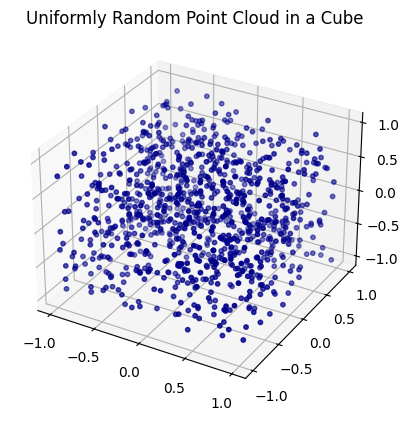

In [38]:
# Generate a cube in R^3 with uniformly random points
N = 1000 # number of points in the cloud
np.random.seed(6111983)
x = np.random.uniform(-1,1,N*3).reshape((N, 3)) # points
# Plot the cube
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker='o', s=10, c='darkblue')
plt.title('Uniformly Random Point Cloud in a Cube')
plt.show()

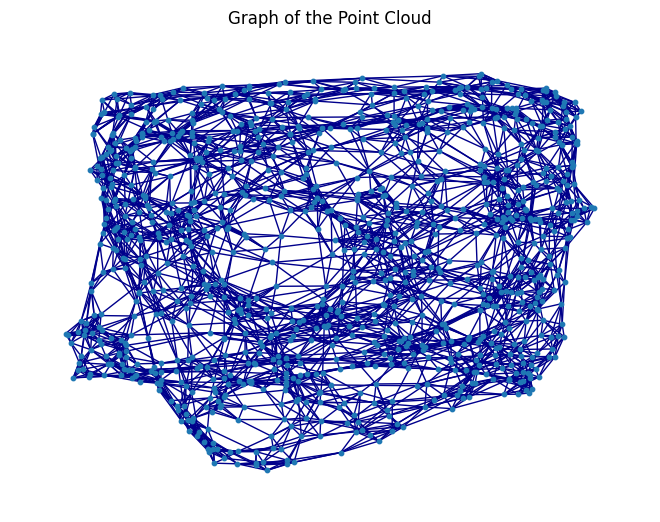

In [39]:
# Build a graph from the point cloud
k = 7 # number of nearest neighbors
G = nx.Graph()
G.add_nodes_from(range(N))
knn = NearestNeighbors(n_neighbors=k+1, algorithm='auto')
distances, indices = knn.fit(x).kneighbors(x)
for i in range(N):
    for j in range(1,k+1): # exclude self-loops
        G.add_edge(i, indices[i,j], weight=1/distances[i,j])
# Plot the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False,node_size=10,edge_color='darkblue')
plt.title('Graph of the Point Cloud')
plt.show()

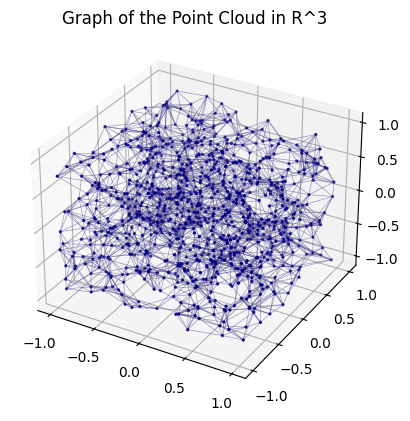

In [40]:
# Plot the cube
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker='o', s=2, c='navy')
# Plot the edges
for edge in G.edges():
    x1, y1, z1 = x[edge[0]]
    x2, y2, z2 = x[edge[1]]
    ax.plot([x1, x2], [y1, y2], [z1, z2], c='darkslateblue', linewidth=0.5, alpha=0.5)
plt.title('Graph of the Point Cloud in R^3')
plt.show()

## Orthonormal Basis Approximation

In [ ]:
# Local PCA to approximate the orthonormal bases
# Find the neighbors of every point within a radius eps_pca
eps_pca = 0.3 # epsilon for the local PCA
pca_neighbors = []
for i in range(N):
    pca_neighbors_of_i = []
    for j in G.neighbors(i): # OR for j in range(N) ?? (edge neighbors or distance neighbors?)
        if np.linalg.norm(x[i]-x[j]) < eps_pca:
            pca_neighbors_of_i.append(x[j])
    pca_neighbors.append(np.array(pca_neighbors_of_i))

In [43]:
# Shifted pca neighbors (X_i matrices in the paper)
shifted_pca_neighbors = [(pca_neighbors[i]-x[i]).transpose(1,0) for i in range(N)] # 3 x Ni matrices

# Epanechnikov kernel
def K(u):
    return (1-u**2)*(u>=0)*(u<=1)


In [44]:
min([len(pca_neighbors[i]) for i in range(N)])

2

In [45]:
shifted_pca_neighbors[0].shape

(3, 9)

In [46]:
# Scaling matrices (D_i in the paper)
scaling_matrices = [ # Ni x Ni matrices, Ni = number of neighbors of point i
    np.diag(
        [np.sqrt(K(np.linalg.norm(shifted_pca_neighbors[i][:,j])/ (np.sqrt(eps_pca))))
         for j in range(shifted_pca_neighbors[i].shape[1])]
    )
    for i in range(N)
]

In [47]:
scaling_matrices[0].shape

(9, 9)

In [48]:
# Scale the shifted pca neighbor matrices (B_i matrices in the paper)
scaled_shifted_pca_neighbors = [shifted_pca_neighbors[i] @ scaling_matrices[i] for i in range(N)]   # 3 x Ni matrices 

In [49]:
scaled_shifted_pca_neighbors[0].shape

(3, 9)

In [50]:
# Singular value decomposition of the scaled shifted pca neighbor matrices
neighbor_matrices_svd =[np.linalg.svd(scaled_shifted_pca_neighbors[i]) for i in range(N)]

In [51]:
neighbor_matrices_svd[0][0].shape, neighbor_matrices_svd[0][1].shape, neighbor_matrices_svd[0][2].shape

((3, 3), (3,), (9, 9))

In [52]:
# Threshold the information variability in the data
gamma = 0.9
local_dimensions = []

for i in range(N):
    for d in range(3):
        first_d_singular_values_variability = np.sum(neighbor_matrices_svd[i][1][:d])/np.sum(neighbor_matrices_svd[i][1])
        if first_d_singular_values_variability > gamma:
            break
        local_dimensions.append(d+1)

In [53]:
# Estimate of the manifold dimension (d in the paper)
dim_estimate = int(np.median(local_dimensions))
dim_estimate

2

In [54]:
# Get the orthonormal bases of the tangent vector spaces
orthonormal_bases = [neighbor_matrices_svd[i][2][:,:dim_estimate] for i in range(N)]

## Alignment